In [1]:
from transformers import AutoModelForCausalLM, AutoProcessor, GenerationConfig
from PIL import Image
import requests
import torch
import os
import matplotlib.pyplot as plt
import re

2024-12-13 10:12:17.914649: I tensorflow/core/util/port.cc:111] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-12-13 10:12:18.599304: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-12-13 10:12:18.599341: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-12-13 10:12:18.599372: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-12-13 10:12:18.900519: I tensorflow/core/platform/cpu_feature_g

In [2]:
model_name = 'allenai/Molmo-7B-D-0924'

In [3]:
# load the processor
processor = AutoProcessor.from_pretrained(
    model_name,
    trust_remote_code=True,
    torch_dtype='auto',
    device_map='auto'
)

In [4]:
# load the model
model = AutoModelForCausalLM.from_pretrained(
    model_name,
    trust_remote_code=True,
    #torch_dtype='auto',
    torch_dtype=torch.float16,
    device_map='auto'
)


Loading checkpoint shards:   0%|          | 0/7 [00:00<?, ?it/s]

In [5]:
"""
Gibt zwei Arrays zurück, die jeweils die tasks (strings) bzw die Bilder enthalten.
Geht die Folder durch und liest die task aus lang.txt und das bild aus im_0
"""
def extract_tasks_and_images(path_to_directory):
    tasks = []
    images = []

    for experiment in os.listdir(path_to_directory):
        if experiment.startswith("."):
            continue
        subdir_path = os.path.join(path_to_directory, experiment)
        task_file_path = os.path.join(subdir_path, "lang.txt")

        # Get Task
        with open(task_file_path, "r") as lang_file:
            task = lang_file.read()
            tasks.append(task)

        # Get image
        for file in os.listdir(subdir_path):
                    if file.startswith("im_") and file.endswith((".png", ".jpg", ".jpeg")):
                        image_path = os.path.join(subdir_path, file)
                        image = Image.open(image_path)
                        images.append(image)

    return tasks, images        

In [6]:
import abc
class Model_output(abc.ABC):

    @abc.abstractmethod
    def get_labels():
        raise NotImplementedError 

    @abc.abstractmethod
    def get_coordinates():
        raise NotImplementedError

    @abc.abstractmethod
    def get_generated_text():
        raise NotImplementedError


class Molmo_out(Model_output):
    def __init__(self, model_output, log_likelihood, width, height):
        self.labels= []
        self.coordinates = []
        self.generated_text = model_output
        self.log_likelihood = log_likelihood

        
        #Find pattern: (object-name, (x, y))
        #(x1, y1), (x2, y2), (x3, y3), ... 
        pattern = r"\(([^,]+), ([^\)]+)\)"

        #(obj1, (x1, y1)), (obj2, (x2, y2)), (obj3, (x3, y3)), ...
        #pattern = r'\(([^,]+),\s*\((\d+\.?\d*),\s*(\d+\.?\d*)\)\)'
        matches = re.findall(pattern, model_output)
        
        objects = []

        modified_matches = [("", float(x), float(y)) for x, y in matches]
        for object_label, x, y in modified_matches:
            self.labels.append(object_label.strip())
            self.coordinates.append(self._scale_coordinates(x, y, width, height))


    def _scale_coordinates(self, x, y, width, height):
        scaled_x = float(x) / 100 * width
        scaled_y = float(y) / 100 * height
        return (int(scaled_x), int(scaled_y))

    def get_labels(self):
        return self.labels

    def get_coordinates(self):
        return self.coordinates

    def get_generated_text(self):
        return self.generated_text

    def get_log_likelihood(self):
        return self.log_likelihood

In [7]:
"""
Der model-output ist bei mir (obj1, (x1, y1)), (obj2, (x2, y2,)), ...
Die Methode zieht da einfach die einzelnen Sachen raus
Gibt einen Array aus 3-Tupeln zurück [(ob1, x1, y1), (ob2, x2, y2), ...]
"""
"""
def extract_objects_from_model_output(model_output):
    #Find pattern: (object-name, (x, y))
    pattern = r'\(([^,]+),\s*\((\d+\.?\d*),\s*(\d+\.?\d*)\)\)'
    matches = re.findall(pattern, model_output)
    
    objects = []
    for obj, x, y in matches:
        objects.append((obj.strip(), int(float(x)), int(float(y))))
    return objects
"""

"""
Scaled die Koordinaten auf die Größe des images und gibt diese zurück

def scale_coordinates(coordinates, image_width, image_height):
    scaled_coordinates = []
    for x, y in coordinates:
        # Scale coordinates to the image size
        scaled_x = x / 100 * image_width
        scaled_y = y / 100 * image_height
        scaled_coordinates.append((int(scaled_x), int(scaled_y)))
    return scaled_coordinates
"""

'\nScaled die Koordinaten auf die Größe des images und gibt diese zurück\n\ndef scale_coordinates(coordinates, image_width, image_height):\n    scaled_coordinates = []\n    for x, y in coordinates:\n        # Scale coordinates to the image size\n        scaled_x = x / 100 * image_width\n        scaled_y = y / 100 * image_height\n        scaled_coordinates.append((int(scaled_x), int(scaled_y)))\n    return scaled_coordinates\n'

In [8]:
"""
Nimmt die Objekte und visualisiert diese auf dem image.
labels ist ein Array, der die jeweiligen labels sind, die dann angezeigt werden (Also Prompt: 1, Prompt: 2, ... oder Temp: 1, Temp: 2, ...)
sets_of_objects is ein Array, der Listen enthält, welche die Objekte speichern. Also jede Liste ist ein run mit dem Model (Hier werden ja immer mehrere Punkte ausgegeben, deshalb ist ein run selbst auch eine Liste)
Und weil wir ja bspw. alle temperatures, oder alle prompts in einer Grafik haben wollen, müssen die halt alle jeweils nochmal in einer Liste zusammengefasst werden
"""
def visualize_points_on_image(image, labels, model_outs):
    plt.imshow(image, alpha=0.5)

    for i, output in enumerate(model_outs):
        coordinates = output.get_coordinates()
        x_coords = [coord[0] for coord in coordinates]
        y_coords = [coord[1] for coord in coordinates]

        plt.scatter(x_coords, y_coords, marker='o', label=labels[i])

    
    # Add labels and show the plot
    plt.title("Coordinates on Image")
    plt.legend(loc="lower right")
    plt.axis("on")  # Show axes
    plt.show()
    plt.close()

In [9]:
"""
Hier sind die prompts für die VLM. Der Anfang und das Ender sind immer identisch und die Task wird im Skript später automatisch eingesetzt.
Die verschiedenen Prompts können dann über die Liste ausgewählt werden.
"""
#"Locate several points within the vacant space for the following task: " + task + "Your answer should be formatted as a list of tuples, i.e. [(x1, y1), (x2, y2), ...], where each tuple contains the x and y coordinates of a point satisfying the conditions above. The coordinates should be between 0 and 1, indicating the normalized pixel locations of the points in the image."

prompt_start = "You are the robot in the picture. Your task is to: "

prompts = []
prompt_1 = " To complete this task, find the relevant object that you have to move and the place to move it to. Point to these."
#prompt_1 = "First, create a plan how to execute the task. Afterwards, find the relevant objects from your plan in the picture and point to them as well as the robot arm, if that is in the picture."
prompt_2 = "To complete this taks, First create a plan to execute the task. Afterwards find the relevant objects for the task. Then point to the relevant objects in the picture, as well as the robot arm if that is in the picture."
#robo_point_prompt = "Locate several points within the vacant space for the following task: "
prompt_3 = "To complete this taks, first find the relevant objects from the task. Reason, why you need them to complete the task. Then pinpoint the relevant objects in the picture, as well as the robot arm."
#prompt_4 = "To complete this task, first find the relevant objects in the picture. Afterwards create a plan to execute the task."
#prompt_4 = "Find objects, that are not relevant for completing this task."

prompts = [prompt_1, prompt_2, prompt_3]
#prompts = [prompt_1, prompt_2, prompt_3, prompt_4]
#robo_point_end = "Your answer should be formatted as a list of tuples, i.e. [(x1, y1), (x2, y2), ...], where each tuple contains the x and y coordinates of a point satisfying the conditions above. The coordinates should be between 0 and 1, indicating the normalized pixel locations of the points in the image."
#prompt_end = " Your output format should be like this: (name of object 1, (x1, y1)), (name of object 2, (x2, y2)), ..., with x and y beeing integer values. Dont output anything else."
prompt_end = " Your output format should be like this: (x1, y1), (x2, y2), ..., with x and y beeing integer values. Dont output anything else."

In [10]:
temperatures = [0.3, 0.4, 0.6, 0.7]

In [12]:
def group_objects(objects):

    most_objects = 0
    for run in objects:
        most_objects = max(most_objects, len(run))

    grouped_objects = []
    ground_truthes = []
    labels = []

    for i in range(most_objects):
        object_coordinates = []
        for run in objects:
            if i < len(run):
                object = run[i]
                object_coordinates.append((object[1], object[2]))
        grouped_objects.append(object_coordinates)
        ground_truthes.append(object_coordinates[0])


    return grouped_objects, ground_truthes

In [81]:
import numpy as np

def plot_euclidean_bplot(outputs):
    labels = ["Object to move", "Where to place"]
    #TODO - Implement groud_truthes - In the moment just the first run
    ground_truth_coordinates = outputs[0].get_coordinates()
    #TODO - IN the moment just hardcoded to two plots. The object to move and the place to put it at
    data = []
    for i in range(2):
        distances = []
        ground_truth = ground_truth_coordinates[i]
        for run in outputs:
            point = run.get_coordinates()[i]
            euc_dist = np.sqrt(np.square(ground_truth[0] - point[0]) + np.square(ground_truth[1] - point[1]))
            distances.append(euc_dist)
        data.append(distances)

    # Create the boxplots side by side
    plt.boxplot(data, positions=[1, 2], widths=0.6)
    plt.xticks([1, 2], labels)  # Set x-axis labels
    plt.ylabel('Euclidean distance from ground truth')
    plt.title('Euclidean Distance Boxplots')
    plt.show()

In [57]:
from torch.nn.functional import log_softmax
def infer_output_and_log_likelihood(image, prompt, temperature=0.2):
    # Process inputs
    inputs = processor.process(
        images=image,
        text=prompt
    )
    inputs = {k: v.to(model.device).unsqueeze(0) for k, v in inputs.items()}

    # Generate output and compute logits
    with torch.autocast(device_type="cuda", enabled=True, dtype=torch.bfloat16):
        # Generate output
        output = model.generate_from_batch(
            inputs,
            GenerationConfig(max_new_tokens=200, stop_strings="<|endoftext|>", temperature=temperature, do_sample=True),
            tokenizer=processor.tokenizer,
            return_dict_in_generate=True,
            output_logits=True
        )

        output_text = generate_output_text(output, inputs)
        log_likelihood = generate_log_likelihood(output)

    return output_text, log_likelihood

In [55]:
def generate_output_text(output, inputs):
    # Access generated sequences
    generated_tokens = output.sequences[0, inputs['input_ids'].size(1):]
    # Decode the generated tokens
    generated_text = processor.tokenizer.decode(generated_tokens, skip_special_tokens=True)
    return generated_text

def generate_log_likelihood(output):
    logits = output.logits # Shape: [batch_size, seq_len, vocab_size]
    logits = torch.cat(logits, dim=0)
    softmax_fn = torch.nn.Softmax(dim=-1)

    logit_probs = softmax_fn(logits)
    highest_probs, _ = torch.max(logit_probs, dim=-1)
    output_log_probs = torch.log(highest_probs)
    log_likelihood = torch.sum(output_log_probs)

    return log_likelihood.item()

In [56]:
tasks, images = extract_tasks_and_images("./data2")
image = images[0]
task = tasks[0]
prompt = prompt_start + task + prompts[0] + prompt_end

print("Tokens for special characters")
special_chars = [",", "(", ")"]
token_ids = processor.tokenizer.convert_tokens_to_ids(special_chars)
print(token_ids)
print("")

text, ll = do_inference_and_log_likelihood(image, prompt)
print(f"Output: {text}")
print(f"Log Likelihood: {ll}")

Tokens for special characters
[11, 7, 8]

Output:  (27.2, 28.6), (27.2, 43.0)
Log Likelihood: -15.309730529785156


In [ ]:
for i in range(len(tasks)):
    print(f"Task: {task}")
    image = images[i]
    task = tasks[i]
    
    labels = []
    outputs = []
    print("Different Prompts:")
    for j in range(len(prompts)):
        labels.append(f"Prompt: {j + 1}")
        prompt = prompt_start + task + prompts[j] + prompt_end
        
        
        output, likelihood = do_inference_and_log_likelihood(image, prompt)
        molmo_out = Molmo_out(output, image.width, image.height)
        outputs.append(molmo_out)
    
        print(f"Prompt: {j + 1} - Output: {molmo_out.get_generated_text()}")
        print(f"The log-likelihood is: {likelihood}")

    
    visualize_points_on_image(image, labels, outputs)
    print("")
    print("")

Task: Move the can from the top left of the burner to the bottom left of the burner
Multiple runs:
Run: 1 - Output:  (27.4, 26.3), (27.4, 50.8) - Log-Likelihood: -14.029561996459961
Run: 2 - Output:  (27.2, 26.2), (27.2, 50.0) - Log-Likelihood: -14.055706024169922
Run: 3 - Output:  (27.4, 26.7), (27.4, 50.4) - Log-Likelihood: -14.000995635986328
Run: 4 - Output:  (27.7, 28.3), (27.7, 50.0) - Log-Likelihood: -13.939385414123535


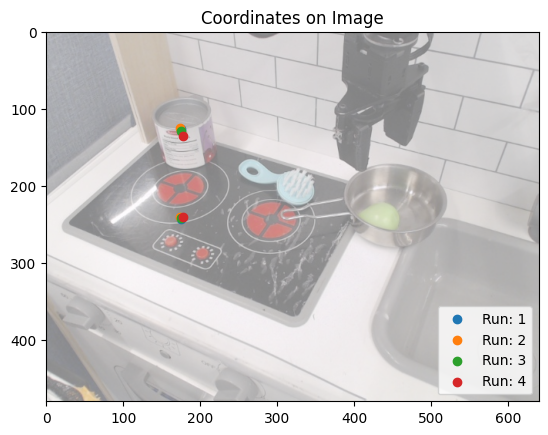

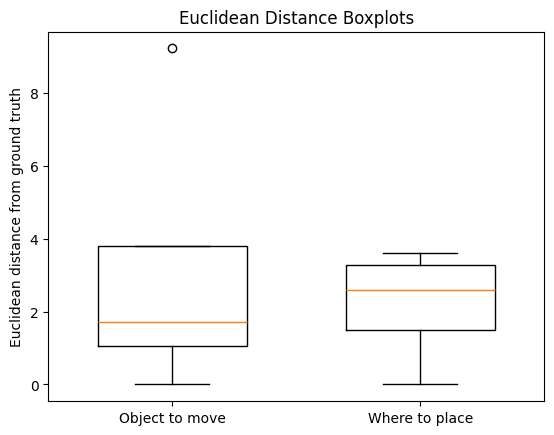



Testing different Temperatures:
Temperature: 0.3 - Output:  (27.7, 28.0), (28.0, 54.3) - Log-Likelihood: -15.143083572387695
Temperature: 0.4 - Output:  (27.4, 25.0), (27.4, 50.0) - Log-Likelihood: -13.169683456420898
Temperature: 0.6 - Output:  (29.0, 30.1), (29.0, 42.3) - Log-Likelihood: -13.322881698608398
Temperature: 0.7 - Output:  (27.8, 22.9), (27.8, 29.3) - Log-Likelihood: -14.196084022521973


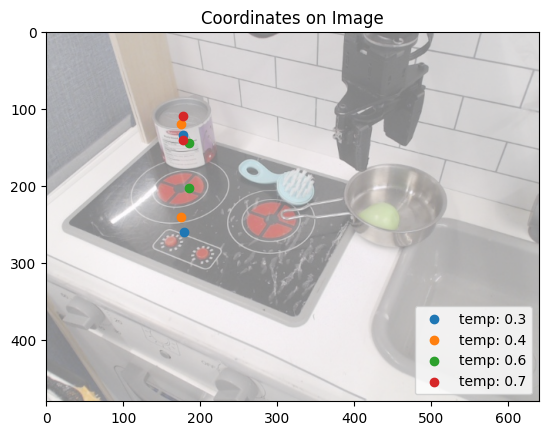

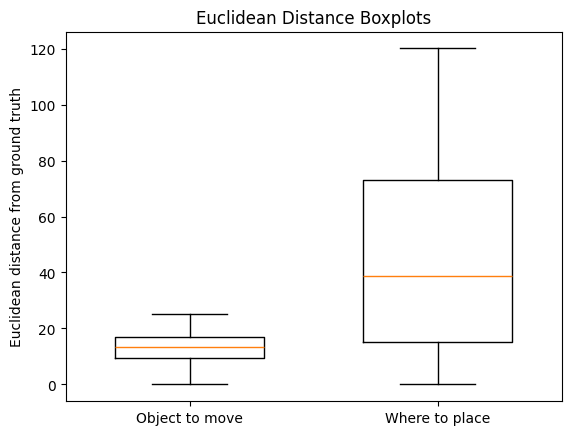



Task: pick up red srewdriver
Multiple runs:
Run: 1 - Output:  (41.0, 32.0), (41.0, 38.2), (41.0, 42.5), (41.0, 45.0), (41.0, 48.0), (41.0, 50.0), (41.0, 52.0), (41.0, 54.0), (41.0, 56.0), (41.0, 58.0), (41.0, 60.0), (41.0, 61.5), (41.0, 63.5), (41.0, 65.0), (41.0, 66.5), (41.0, 68.0), (41.0, 7 - Log-Likelihood: -65.89331817626953
Run: 2 - Output:  (49.3, 36.7), (53.3, 45.0), (75.0, 72.9) - Log-Likelihood: -29.41415023803711
Run: 3 - Output:  (23.9, 23.3), (49.2, 35.3) - Log-Likelihood: -21.486713409423828
Run: 4 - Output:  (26.7, 31.5), (44.7, 40.0) - Log-Likelihood: -22.490015029907227


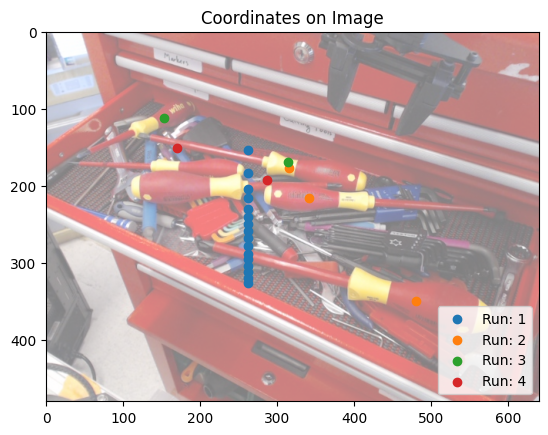

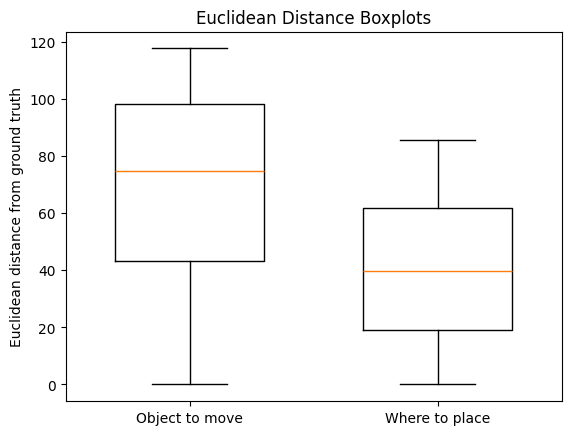



Testing different Temperatures:
Temperature: 0.3 - Output:  (19.7, 25.4), (28.7, 21.8) - Log-Likelihood: -20.6732177734375
Temperature: 0.4 - Output:  (40.6, 39.1), (50.0, 28.9), (73.0, 72.8), (88.8, 77.0) - Log-Likelihood: -39.973960876464844
Temperature: 0.6 - Output:  (40.3, 32.5), (79.6, 19.7) - Log-Likelihood: -21.384103775024414
Temperature: 0.7 - Output:  (36.1, 31.5), (37.9, 40.9), (54.2, 45.6), (76.2, 72.8) - Log-Likelihood: -39.008846282958984


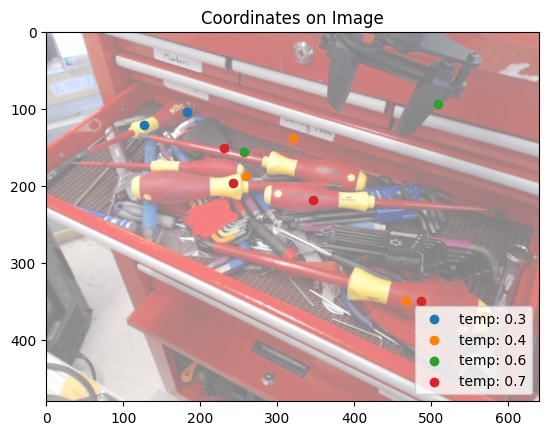

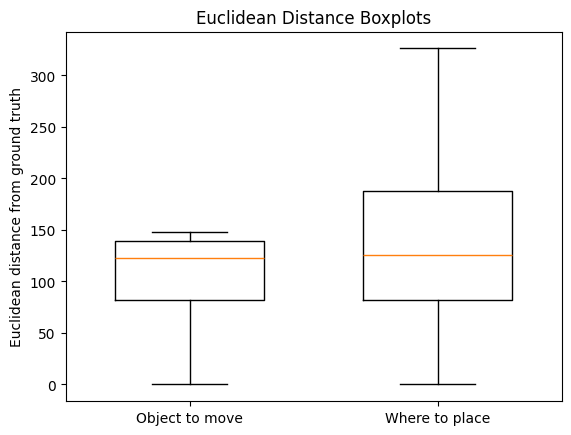



Task: take the eggplant and put it between the two right burners
Multiple runs:
Run: 1 - Output:  (58.8, 46.1), (59.1, 54.8) - Log-Likelihood: -16.858304977416992
Run: 2 - Output:  (55.7, 47.1), (59.7, 52.4) - Log-Likelihood: -18.112621307373047
Run: 3 - Output:  (59.7, 44.5), (59.7, 51.3) - Log-Likelihood: -14.747756958007812
Run: 4 - Output:  (47.6, 42.3), (59.7, 53.2) - Log-Likelihood: -17.475873947143555


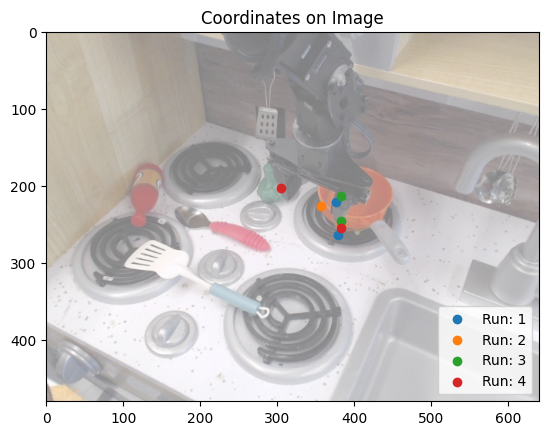

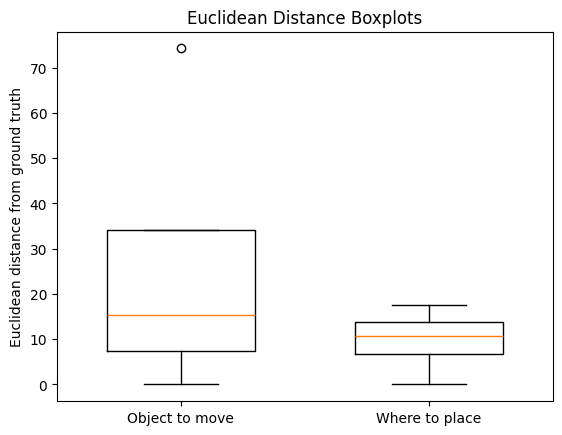



Testing different Temperatures:
Temperature: 0.3 - Output:  (44.5, 40.5), (58.0, 53.2) - Log-Likelihood: -18.825590133666992
Temperature: 0.4 - Output:  (46.1, 43.3), (59.3, 51.5) - Log-Likelihood: -17.809986114501953
Temperature: 0.6 - Output:  (59.8, 45.8), (70.7, 55.0) - Log-Likelihood: -15.43384838104248
Temperature: 0.7 - Output:  (64.4, 39.7), (55.5, 43.6) - Log-Likelihood: -18.14638900756836


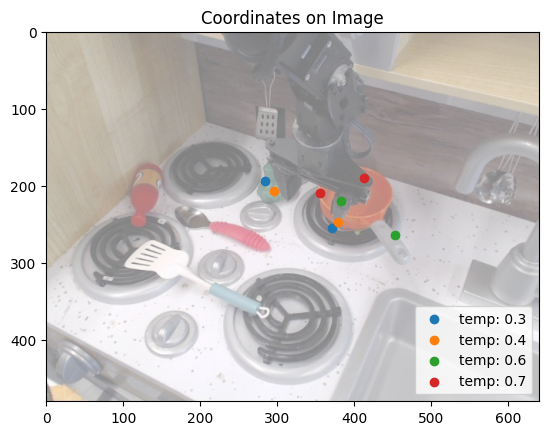

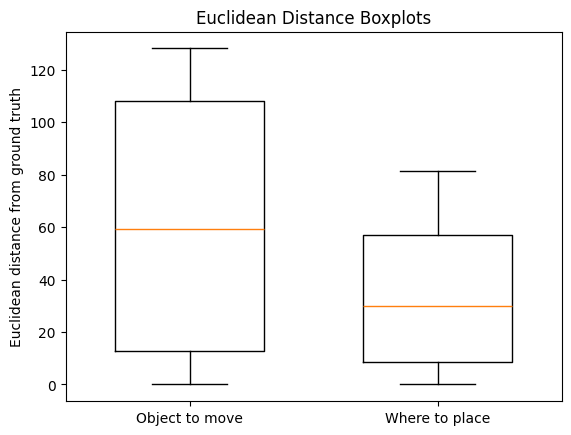



Task: move arch on the table and place it on top of another arch
Multiple runs:
Run: 1 - Output:  (69.5, 78.0), (41.0, 65.0) - Log-Likelihood: -16.87158203125
Run: 2 - Output:  (69.9, 79.5), (41.1, 60.5) - Log-Likelihood: -16.717004776000977
Run: 3 - Output:  (69.2, 77.5), (41.2, 69.2) - Log-Likelihood: -16.35540771484375
Run: 4 - Output:  (69.0, 79.8), (41.1, 66.9) - Log-Likelihood: -16.51978302001953


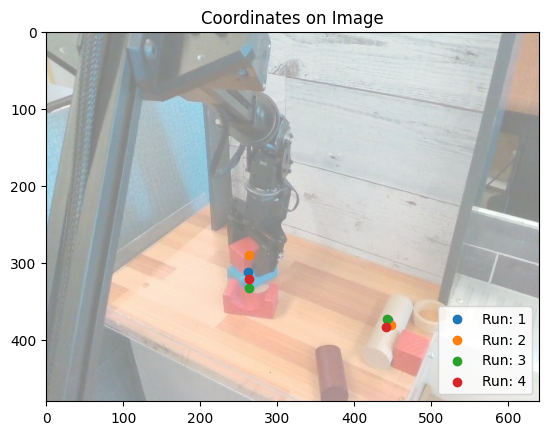

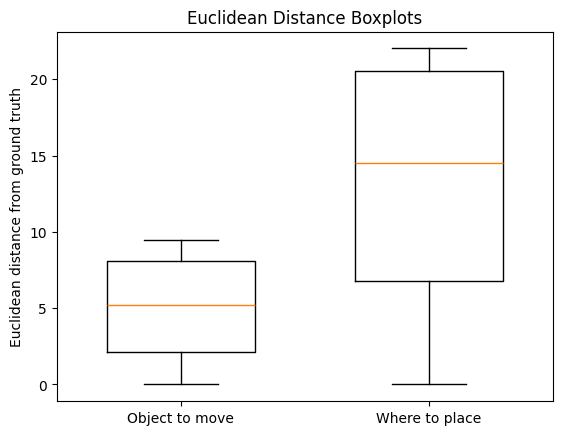



Testing different Temperatures:
Temperature: 0.3 - Output:  (69.8, 78.4), (40.5, 69.6) - Log-Likelihood: -16.340147018432617
Temperature: 0.4 - Output:  (50.2, 63.0), (50.2, 70.5) - Log-Likelihood: -16.710102081298828
Temperature: 0.6 - Output:  (44.3, 67.6), (66.2, 72.0) - Log-Likelihood: -18.158138275146484
Temperature: 0.7 - Output:  (70.3, 78.0), (41.4, 66.3) - Log-Likelihood: -15.899618148803711


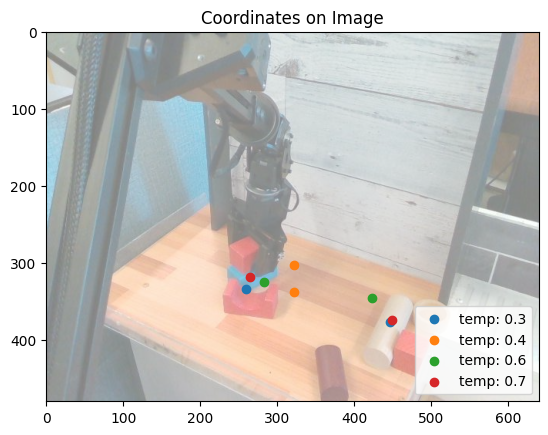

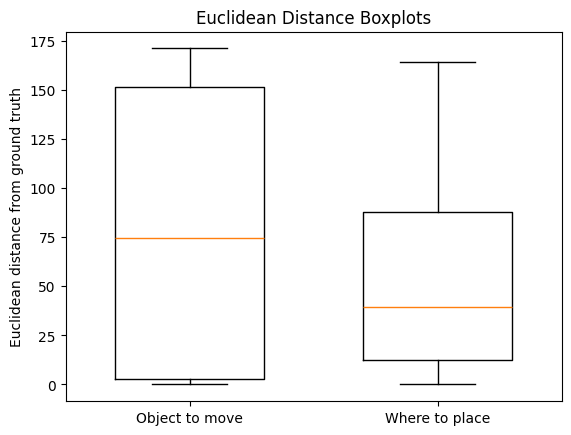



Task: take sushi out of pan
Multiple runs:
Run: 1 - Output:  (30.5, 23.4), (33.9, 20.1) - Log-Likelihood: -16.910362243652344
Run: 2 - Output:  (31.5, 23.5), (33.2, 20.3), (34.4, 24.4), (36.0, 21.6), (37.0, 25.7) - Log-Likelihood: -40.84379577636719
Run: 3 - Output:  (31.5, 23.0), (33.5, 22.3) - Log-Likelihood: -16.958694458007812
Run: 4 - Output:  (31.6, 24.4), (32.3, 19.6) - Log-Likelihood: -15.869524002075195


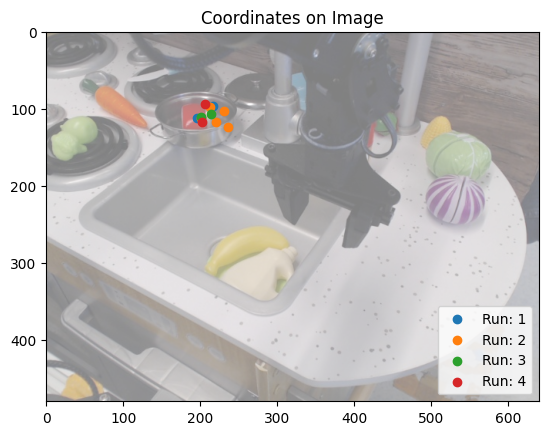

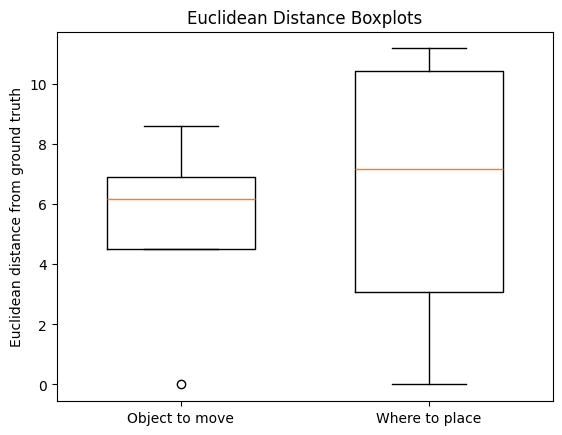



Testing different Temperatures:
Temperature: 0.3 - Output:  (32.3, 23.1), (33.1, 30.6) - Log-Likelihood: -15.833601951599121
Temperature: 0.4 - Output:  (31.0, 22.7), (32.7, 18.9) - Log-Likelihood: -15.229427337646484
Temperature: 0.6 - Output:  (30.0, 24.1), (31.2, 33.4) - Log-Likelihood: -14.63123893737793
Temperature: 0.7 - Output:  (28.4, 21.0), (32.4, 21.0), (43.3, 62.7), (44.9, 57.9) - Log-Likelihood: -33.67967224121094


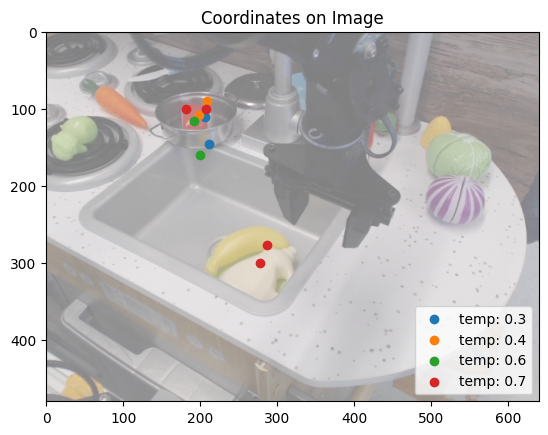

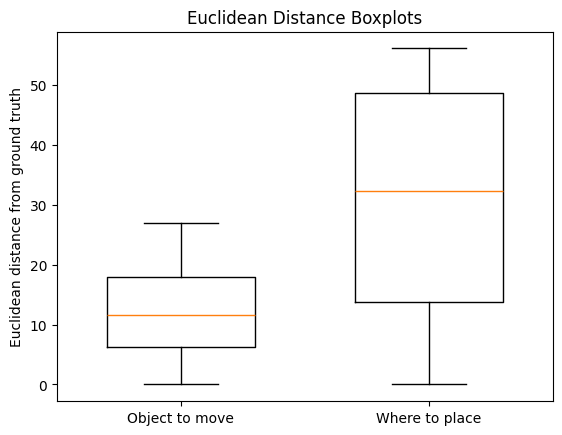



Task: pick up glass cup
Multiple runs:
Run: 1 - Output:  (40.7, 46.0), (50.5, 38.1) - Log-Likelihood: -18.419498443603516
Run: 2 - Output:  (40.0, 59.5), (52.1, 39.1) - Log-Likelihood: -17.622800827026367
Run: 3 - Output:  (42.0, 44.5), (54.6, 38.6) - Log-Likelihood: -18.217971801757812
Run: 4 - Output:  (40.1, 62.5), (52.3, 39.6) - Log-Likelihood: -18.217634201049805


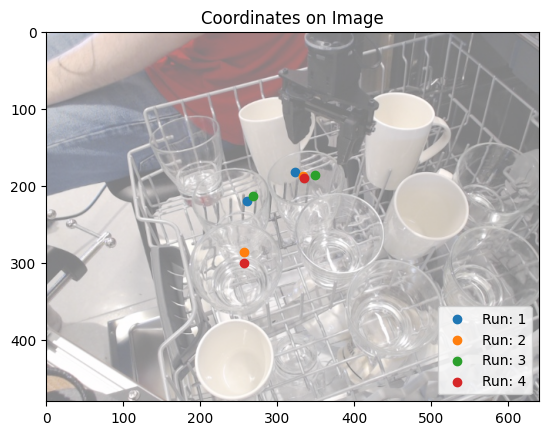

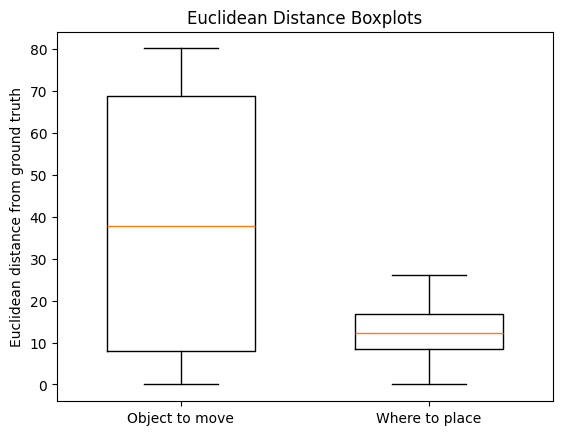



Testing different Temperatures:
Temperature: 0.3 - Output:  (42.1, 44.8), (52.3, 39.4) - Log-Likelihood: -18.848773956298828
Temperature: 0.4 - Output:  (42.8, 63.1), (51.0, 39.6) - Log-Likelihood: -18.432024002075195
Temperature: 0.6 - Output:  (51.6, 43.0), (56.9, 58.4), (73.5, 73.6) - Log-Likelihood: -26.153087615966797
Temperature: 0.7 - Output:  (45, 50), (49, 15) - Log-Likelihood: -10.334098815917969


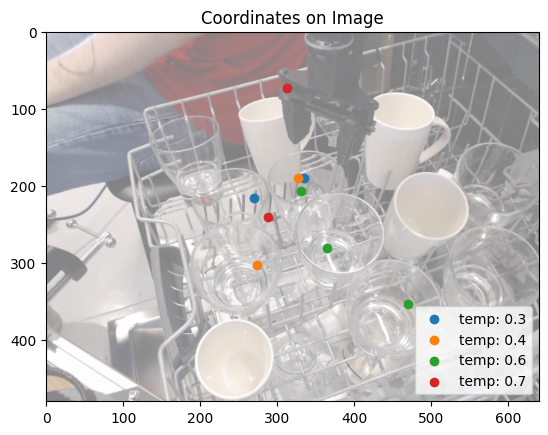

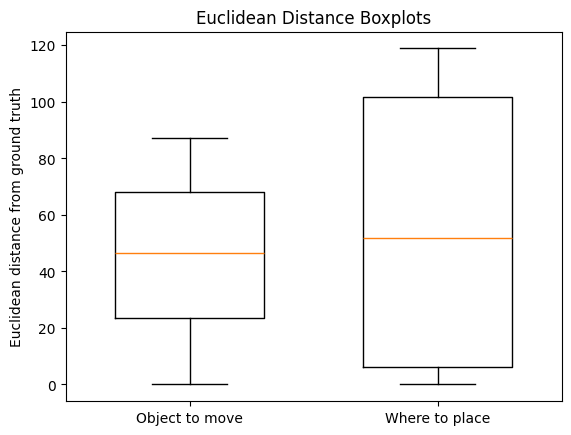



Task: open low fridge
Multiple runs:
Run: 1 - Output:  (59.6, 61.4), (59.6, 79.2) - Log-Likelihood: -16.192062377929688
Run: 2 - Output:  (60.6, 59.5), (43.5, 15.9) - Log-Likelihood: -19.426721572875977
Run: 3 - Output:  (58.8, 60.5), (59.1, 79.0) - Log-Likelihood: -18.348278045654297
Run: 4 - Output:  (60.0, 60.0), (45.0, 45.0) - Log-Likelihood: -12.697013854980469


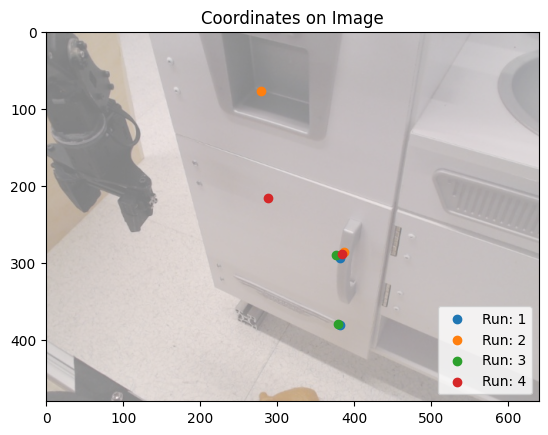

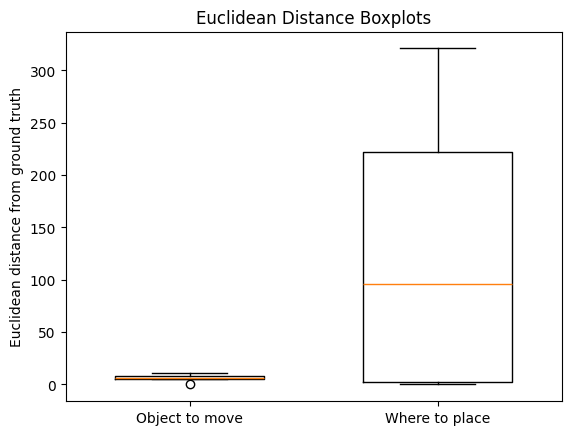



Testing different Temperatures:
Temperature: 0.3 - Output:  (59.2, 61.7), (59.5, 52.0) - Log-Likelihood: -17.153575897216797
Temperature: 0.4 - Output:  (58.0, 62.1), (59.0, 51.0) - Log-Likelihood: -18.492746353149414
Temperature: 0.6 - Output:  (58.0, 59.2), (48.7, 20.1) - Log-Likelihood: -19.804157257080078
Temperature: 0.7 - Output:  (57.9, 61.5), (43.4, 20.3) - Log-Likelihood: -19.15866470336914


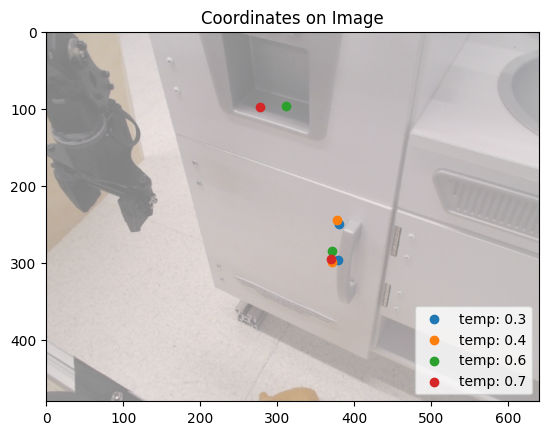

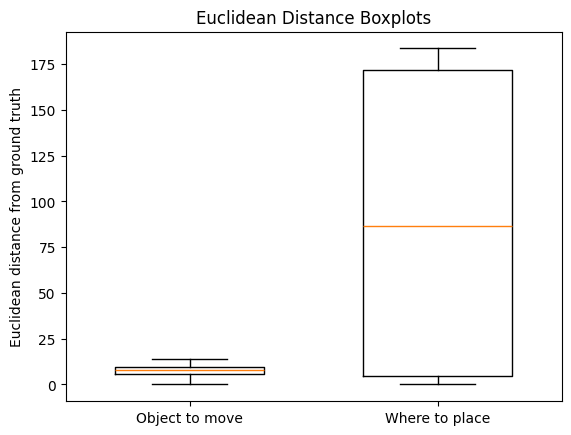



Task: Place the pot to the right of the blue fork.
Move silver pot to lower right corner of the table.
Multiple runs:
Run: 1 - Output:  (45, 38), (87, 80) - Log-Likelihood: -10.114330291748047
Run: 2 - Output:  (45, 38), (85, 60) - Log-Likelihood: -9.078766822814941
Run: 3 - Output:  (45, 40), (85, 60) - Log-Likelihood: -7.5960259437561035
Run: 4 - Output:  (45, 36), (85, 60) - Log-Likelihood: -8.762439727783203


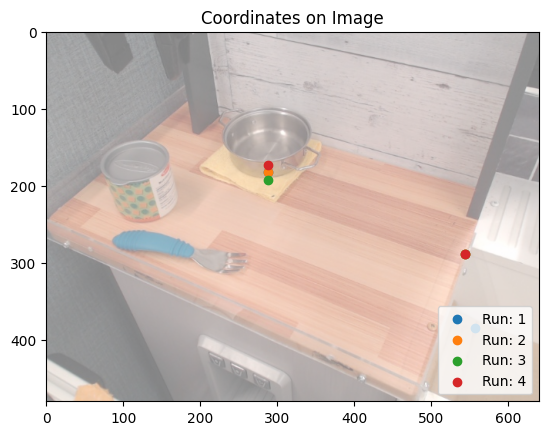

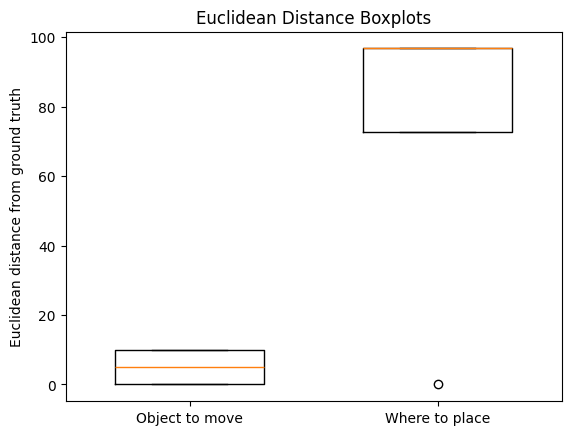



Testing different Temperatures:
Temperature: 0.3 - Output:  (45, 33), (89, 69) - Log-Likelihood: -10.465503692626953
Temperature: 0.4 - Output:  (46.3, 35.5), (88.9, 90.9) - Log-Likelihood: -17.386110305786133
Temperature: 0.6 - Output:  (45, 31), (85, 62) - Log-Likelihood: -9.449252128601074
Temperature: 0.7 - Output:  (45, 32), (50, 60) - Log-Likelihood: -8.465751647949219


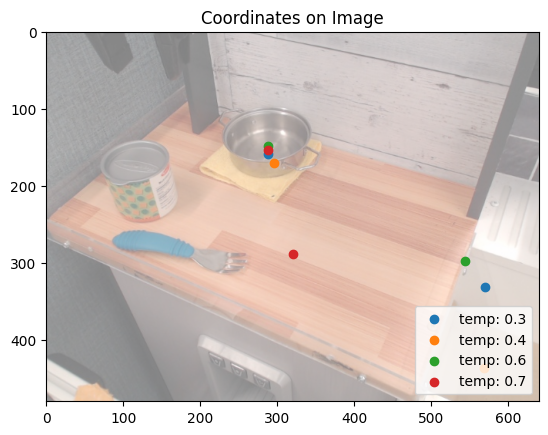

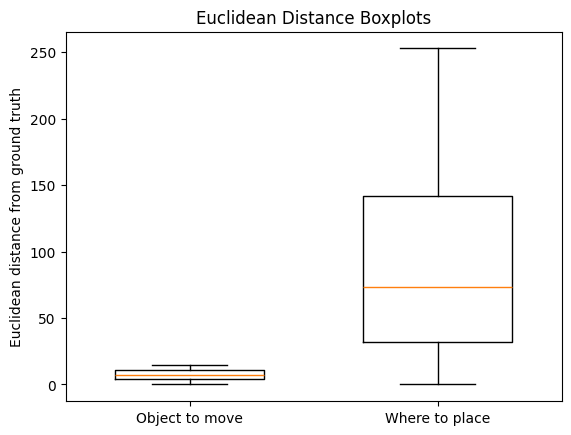

In [82]:
"""
Das ist mein Script, dass die Experimente ausführt
Für alle tasks 3 mal das gleiche: 1. Für verschiedene prompts, 2. Für das gleiche prompt und gleiche temperature, 3. Für verschiedene temperatures 
"""

#tasks, images = extract_tasks_and_images("./data")
tasks, images = extract_tasks_and_images("./data2")

for i in range(len(tasks)):
    image = images[i]
    task = tasks[i]
    print(f"Task: {task}")

    """
    labels = []
    outputs = []
    print("Different Prompts:")
    for j in range(len(prompts)):
        labels.append(f"Prompt: {j + 1}")
        prompt = prompt_start + task + prompts[j] + prompt_end
        
        
        output, log_likelihood = infer_output_and_log_likelihood(image, prompt)
        molmo_out = Molmo_out(output, image.width, image.height)
        outputs.append(molmo_out)
    
        print(f"Prompt: {j + 1} - Output: {molmo_out.get_generated_text()}")

    
    visualize_points_on_image(image, labels, outputs)
    print("")
    print("")

    """
    prompt = prompt_start + task + prompts[0] + prompt_end
    labels = []
    outputs = []
    print("Multiple runs:")
    for j in range(4):
        labels.append(f"Run: {j + 1}")
        
        output, log_likelihood = infer_output_and_log_likelihood(image, prompt)
        molmo_out = Molmo_out(output, image.width, image.height)
        outputs.append(molmo_out)
    
        print(f"Run: {j + 1} - Output: {molmo_out.get_generated_text()} - Log-Likelihood: {log_likelihood}")

    visualize_points_on_image(image, labels, outputs)
    plot_euclidean_bplot(outputs)
    print("")
    print("")

    labels = []
    outputs = []
    print("Testing different Temperatures:")
    for j in range(len(temperatures)):
        temp = temperatures[j]
        labels.append(f"temp: {temp}")
        
        output, log_likelihood = infer_output_and_log_likelihood(image, prompt, temp)
        molmo_out = Molmo_out(output, image.width, image.height)
        outputs.append(molmo_out)
    
        print(f"Temperature: {temp} - Output: {molmo_out.get_generated_text()} - Log-Likelihood: {log_likelihood}")

    visualize_points_on_image(image, labels, outputs)
    plot_euclidean_bplot(outputs)
    print("")
    print("")